In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from tqdm import tqdm
from cartopy import crs as ccrs

from nzdownscale.dataprocess.config_local import DATA_PATHS
from nzdownscale.dataprocess.config import VAR_ERA5, VAR_STATIONS
from nzdownscale.dataprocess import era5, stations, wrf

/home/emily/mambaforge/envs/deepsensor2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
u_var = '10m_u_component_of_wind'
v_var = '10m_v_component_of_wind'
year = 2020

# Load ERA5

In [4]:
process_era5 = era5.ProcessERA5()

u_era5_var = VAR_ERA5[u_var]['var_name']
u_era5_ds = process_era5.load_ds(u_var, year)
u_era5_ds = u_era5_ds.compute()

v_era5_var = VAR_ERA5[v_var]['var_name']
v_era5_ds = process_era5.load_ds(v_var, year)
v_era5_ds = v_era5_ds.compute()

# Load stations

In [5]:
process_stations = stations.ProcessStations()

u_station_var = VAR_STATIONS[u_var]['var_name']
v_station_var = VAR_STATIONS[v_var]['var_name']
station_df = process_stations.load_stations(u_var, year, return_uv=True)

Filtering stations: 100%|██████████| 208/208 [00:44<00:00,  4.70it/s]


Concatenating stations into pd.DataFrame


In [ ]:
station_df

In [ ]:
len_df = len(station_df)
station_df = station_df.dropna(subset=[u_station_var, v_station_var])
print(f'Dropped {len_df - len(station_df)} NaN values')
station_df

# Plots

In [ ]:
u_era5_mean = float(u_era5_ds[u_era5_var].mean(dim=['time', 'latitude', 'longitude']).values)
u_station_mean = np.mean(station_df[u_station_var].values)
print('U-component of wind:')
print(f'ERA5 overall mean: {u_era5_mean}, \nStation overall mean: {u_station_mean}')

v_era5_mean = float(v_era5_ds[v_era5_var].mean(dim=['time', 'latitude', 'longitude']).values)
v_station_mean = np.mean(station_df[v_station_var].values)
print('V-component of wind:')
print(f'ERA5 overall mean: {v_era5_mean}, \nStation overall mean: {v_station_mean}')

In [ ]:
u_era5_mean_by_month = u_era5_ds[u_era5_var].groupby('time.month').mean(dim=['time', 'latitude', 'longitude']).values

station_df_reset = station_df.reset_index()
station_df_reset['time'] = pd.to_datetime(station_df_reset['time'])
station_df_reset = station_df_reset.set_index('time')
u_station_mean_by_month = station_df_reset[u_station_var].resample('ME').mean().values

fig, ax = plt.subplots()
ax.plot(np.arange(1, 13), u_era5_mean_by_month, label='ERA5', marker='o')
ax.plot(np.arange(1, 13), u_station_mean_by_month, label='Station', marker='o')
ax.set_xlabel('Month')
ax.set_ylabel('Surface Pressure (hPa)')
ax.legend()
ax.set_title(f'{u_var} mean by month, {year}')
plt.show();

v_era5_mean_by_month = v_era5_ds[v_era5_var].groupby('time.month').mean(dim=['time', 'latitude', 'longitude']).values
v_station_mean_by_month = station_df_reset[v_station_var].resample('ME').mean().values

fig, ax = plt.subplots()
ax.plot(np.arange(1, 13), v_era5_mean_by_month, label='ERA5', marker='o')
ax.plot(np.arange(1, 13), v_station_mean_by_month, label='Station', marker='o')
ax.set_xlabel('Month')
ax.set_ylabel('Surface Pressure (hPa)')
ax.legend()
ax.set_title(f'{v_var} mean by month, {year}')
plt.show();


# By station

In [ ]:
stations = station_df_reset['station_name'].unique()

In [ ]:
u_stats_by_station = {}
v_stats_by_station = {}
for station in tqdm(stations):
    station_data = station_df_reset[station_df_reset['station_name'] == station]
    
    u_station_data_vals = station_data[u_station_var]
    u_station_mean = u_station_data_vals.mean()
    u_station_std = u_station_data_vals.std()

    u_era5_data = u_era5_ds[u_era5_var].sel(latitude=station_data['latitude'].unique()[0],
                                       longitude=station_data['longitude'].unique()[0],
                                       method='nearest')
    u_era5_data_vals = u_era5_data.values
    u_era5_mean = u_era5_data_vals.mean()
    u_era5_std = u_era5_data_vals.std()

    u_stats_by_station[station] = {'station_mean': u_station_mean, 
                                 'station_std': u_station_std,
                                 'era5_mean': u_era5_mean,
                                 'era5_std': u_era5_std}

    v_station_data_vals = station_data[v_station_var]
    v_station_mean = v_station_data_vals.mean()
    v_station_std = v_station_data_vals.std()

    v_era5_data = v_era5_ds[v_era5_var].sel(latitude=station_data['latitude'].unique()[0],
                                        longitude=station_data['longitude'].unique()[0],
                                        method='nearest')
    
    v_era5_data_vals = v_era5_data.values
    v_era5_mean = v_era5_data_vals.mean()
    v_era5_std = v_era5_data_vals.std()

    v_stats_by_station[station] = {'station_mean': v_station_mean,
                                    'station_std': v_station_std,
                                    'era5_mean': v_era5_mean,
                                    'era5_std': v_era5_std}

In [ ]:
num_stations = len(u_stats_by_station)

station_names = list(u_stats_by_station.keys())

station_means = [u_stats_by_station[station]['station_mean'] for station in station_names]
station_stds = [u_stats_by_station[station]['station_std'] for station in station_names]

era5_means = [u_stats_by_station[station]['era5_mean'] for station in station_names]
era5_stds = [u_stats_by_station[station]['era5_std'] for station in station_names]

bar_width = 0.35
bar_positions = np.arange(num_stations)

fig, ax = plt.subplots(figsize=(15, 5))

# Plot the station means and stds
ax.bar((bar_positions - bar_width/2)[:50], station_means[:50], bar_width, yerr=station_stds[:50], label='Station')
# Plot the era5 means and stds
ax.bar((bar_positions + bar_width/2)[:50], era5_means[:50], bar_width, yerr=era5_stds[:50], label='ERA5')

ax.set_xticks(bar_positions[:50])
ax.set_xticklabels(station_names[:50], rotation=90)

ax.set_ylabel('10m U Wind Component (m/s)')
ax.set_title('U Wind Station Mean and Std vs ERA5 Mean and Std')
ax.legend()
plt.show();

In [ ]:
num_stations = len(v_stats_by_station)

station_names = list(v_stats_by_station.keys())

station_means = [v_stats_by_station[station]['station_mean'] for station in station_names]
station_stds = [v_stats_by_station[station]['station_std'] for station in station_names]

era5_means = [v_stats_by_station[station]['era5_mean'] for station in station_names]
era5_stds = [v_stats_by_station[station]['era5_std'] for station in station_names]

bar_width = 0.35
bar_positions = np.arange(num_stations)

fig, ax = plt.subplots(figsize=(15, 5))

# Plot the station means and stds
ax.bar((bar_positions - bar_width/2)[:50], station_means[:50], bar_width, yerr=station_stds[:50], label='Station')
# Plot the era5 means and stds
ax.bar((bar_positions + bar_width/2)[:50], era5_means[:50], bar_width, yerr=era5_stds[:50], label='ERA5')

ax.set_xticks(bar_positions[:50])
ax.set_xticklabels(station_names[:50], rotation=90)

ax.set_ylabel('10m V Wind Component (m/s)')
ax.set_title('V Wind Station Mean and Std vs ERA5 Mean and Std')
ax.legend()
plt.show();

# Visualise

In [ ]:
cmap = 'seismic'

### U Wind

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5), **{'subplot_kw': {'projection': ccrs.PlateCarree()}})
mean_era5 = u_era5_ds[u_era5_var].mean(dim='time')
max_era5 = mean_era5.max().values
min_era5 = mean_era5.min().values
mean_era5.plot(ax=ax, 
                cmap=cmap, 
                cbar_kwargs={'label': 'U Wind Component (m/s)'},
                vmin=min_era5, vmax=max_era5)
ax.set_extent([165, 180, -50, -34], crs=ccrs.PlateCarree())

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5), **{'subplot_kw': {'projection': ccrs.PlateCarree()}})
station_means = station_df.groupby(['latitude', 'longitude']).mean().reset_index()
station_means.plot.scatter(x='longitude', 
                           y='latitude',
                           c=station_means[u_station_var], 
                           cmap=cmap,
                           ax=ax,
                           vmin=min_era5, vmax=max_era5)
ax.coastlines()
ax.set_extent([165, 180, -50, -34], crs=ccrs.PlateCarree())

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5), **{'subplot_kw': {'projection': ccrs.PlateCarree()}})

mean_era5.plot(ax=ax, 
                cmap=cmap, 
                cbar_kwargs={'label': 'U Wind Component (m/s))'},
                vmin=min_era5, vmax=max_era5)
station_means.plot.scatter(x='longitude', 
                           y='latitude',
                           c=station_means[u_station_var], 
                           cmap=cmap,
                           ax=ax,
                           vmin=min_era5, vmax=max_era5)

ax.set_extent([165, 180, -50, -34], crs=ccrs.PlateCarree())


### V Wind

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5), **{'subplot_kw': {'projection': ccrs.PlateCarree()}})
mean_era5 = v_era5_ds[v_era5_var].mean(dim='time')
max_era5 = mean_era5.max().values
min_era5 = mean_era5.min().values
mean_era5.plot(ax=ax, 
                cmap=cmap, 
                cbar_kwargs={'label': 'V Wind Component (m/s)'},
                vmin=min_era5, vmax=max_era5)
ax.set_extent([165, 180, -50, -34], crs=ccrs.PlateCarree())

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5), **{'subplot_kw': {'projection': ccrs.PlateCarree()}})
station_means = station_df.groupby(['latitude', 'longitude']).mean().reset_index()
station_means.plot.scatter(x='longitude', 
                           y='latitude',
                           c=station_means[v_station_var], 
                           cmap=cmap,
                           ax=ax,
                           vmin=min_era5, vmax=max_era5)
ax.coastlines()
ax.set_extent([165, 180, -50, -34], crs=ccrs.PlateCarree())

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5), **{'subplot_kw': {'projection': ccrs.PlateCarree()}})

mean_era5.plot(ax=ax, 
                cmap=cmap, 
                cbar_kwargs={'label': 'V Wind Component (m/s))'},
                vmin=min_era5, vmax=max_era5)
station_means.plot.scatter(x='longitude', 
                           y='latitude',
                           c=station_means[v_station_var], 
                           cmap=cmap,
                           ax=ax,
                           vmin=min_era5, vmax=max_era5)

ax.set_extent([165, 180, -50, -34], crs=ccrs.PlateCarree())


Histogram

Text(0.5, 1.0, 'Station U10 winds Histogram')

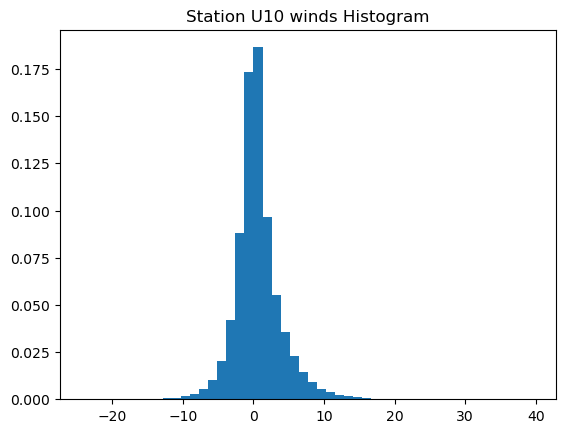

In [6]:
fig, ax = plt.subplots()
ax.hist(station_df['u'].values, bins=50, density=True)
ax.set_title('Station U10 winds Histogram')

Text(0.5, 1.0, 'Station V10 winds Histogram')

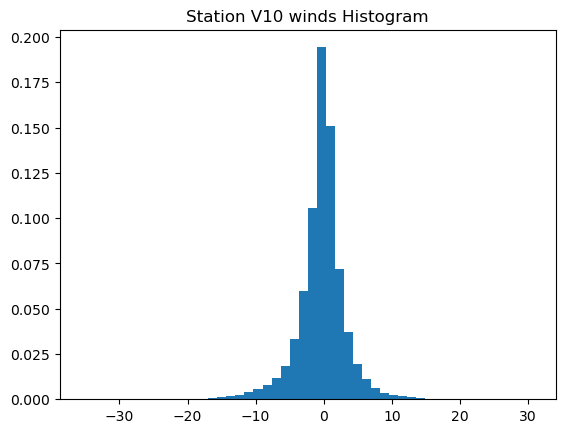

In [7]:
fig, ax = plt.subplots()
ax.hist(station_df['v'].values, bins=50, density=True)
ax.set_title('Station V10 winds Histogram')

<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1124423/432949001.py:17: SyntaxWarning: invalid escape sequence '\m'
  ax.plot(x, p_norm, 'r-', label=f'Normal fit\n$\mu={mu:.2f}$, $\sigma={std:.2f}$')
/tmp/ipykernel_1124423/432949001.py:17: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(x, p_norm, 'r-', label=f'Normal fit\n$\mu={mu:.2f}$, $\sigma={std:.2f}$')


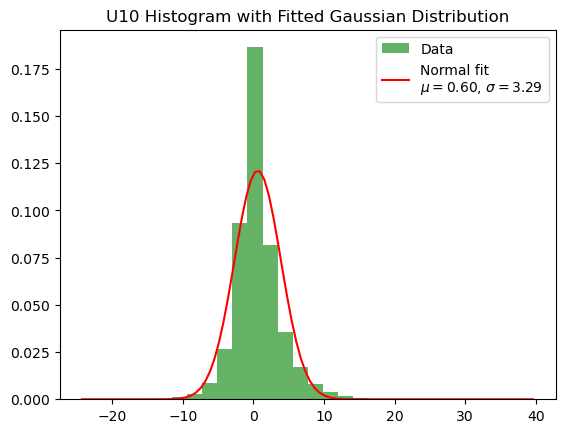

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm, lognorm, beta

# Get the pressure data (replace with your actual column name)
data = station_df['u'].values
data = data[np.isfinite(data)]

# Plot the histogram of the data
fig, ax = plt.subplots()
ax.hist(data, bins=30, density=True, alpha=0.6, color='g', label='Data')

# Fit and plot the Normal distribution
mu, std = norm.fit(data)
x = np.linspace(min(data), max(data), 100)
p_norm = norm.pdf(x, mu, std)
ax.plot(x, p_norm, 'r-', label=f'Normal fit\n$\mu={mu:.2f}$, $\sigma={std:.2f}$')

# Customize plot
ax.set_title('U10 Histogram with Fitted Gaussian Distribution')
ax.legend()

plt.show()


<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1124423/3194577914.py:17: SyntaxWarning: invalid escape sequence '\m'
  ax.plot(x, p_norm, 'r-', label=f'Normal fit\n$\mu={mu:.2f}$, $\sigma={std:.2f}$')
/tmp/ipykernel_1124423/3194577914.py:17: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(x, p_norm, 'r-', label=f'Normal fit\n$\mu={mu:.2f}$, $\sigma={std:.2f}$')


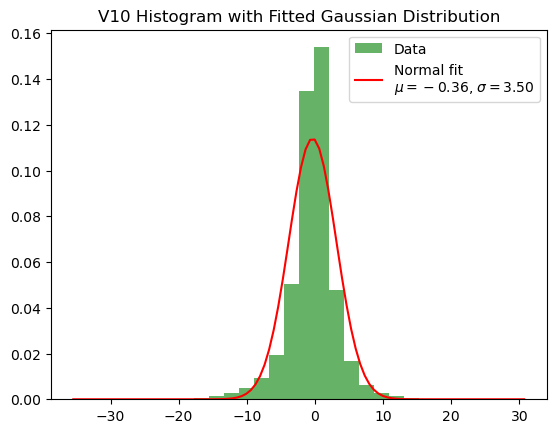

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm, lognorm, beta

# Get the pressure data (replace with your actual column name)
data = station_df['v'].values
data = data[np.isfinite(data)]

# Plot the histogram of the data
fig, ax = plt.subplots()
ax.hist(data, bins=30, density=True, alpha=0.6, color='g', label='Data')

# Fit and plot the Normal distribution
mu, std = norm.fit(data)
x = np.linspace(min(data), max(data), 100)
p_norm = norm.pdf(x, mu, std)
ax.plot(x, p_norm, 'r-', label=f'Normal fit\n$\mu={mu:.2f}$, $\sigma={std:.2f}$')

# Customize plot
ax.set_title('V10 Histogram with Fitted Gaussian Distribution')
ax.legend()

plt.show()


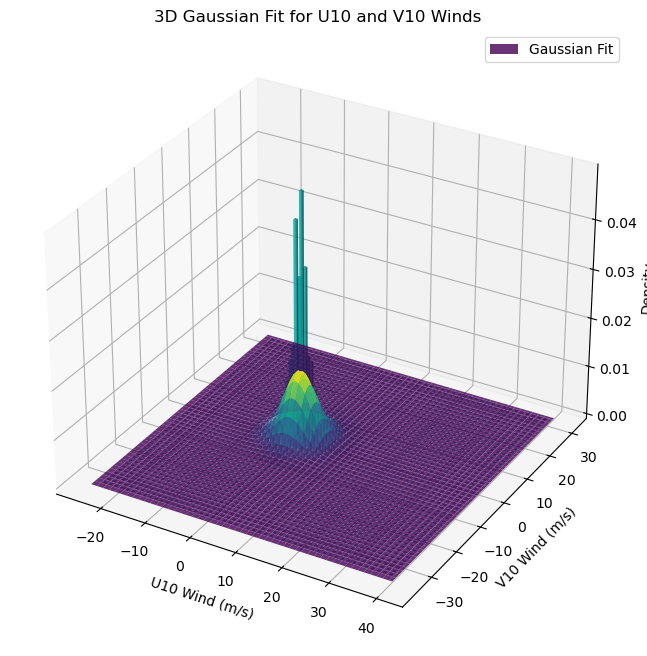

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

# Get the U10 and V10 wind components (replace 'u' and 'v' with actual column names if needed)
u_data = station_df['u'].values
u_data = u_data[np.isfinite(u_data)]

v_data = station_df['v'].values
v_data = v_data[np.isfinite(v_data)]


# Step 1: Calculate the mean and covariance of the U and V wind components
mean = [np.mean(u_data), np.mean(v_data)]
cov = np.cov(u_data, v_data)  # Covariance matrix

# Step 2: Create a grid of points for plotting
x = np.linspace(np.min(u_data) - 1, np.max(u_data) + 1, 100)
y = np.linspace(np.min(v_data) - 1, np.max(v_data) + 1, 100)
X, Y = np.meshgrid(x, y)

# Step 3: Create a 2D Gaussian distribution (PDF) using the multivariate normal distribution
pos = np.dstack((X, Y))
rv = multivariate_normal(mean, cov)
Z = rv.pdf(pos)

# Step 4: Plot the 3D surface plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Surface plot for the Gaussian
ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.8, label=f'Gaussian Fit')

# Step 5: Plot the 3D histogram
hist, xedges, yedges = np.histogram2d(u_data, v_data, bins=50, density=True,)
xpos, ypos = np.meshgrid(xedges[:-1] + 0.5 * (xedges[1] - xedges[0]), 
                         yedges[:-1] + 0.5 * (yedges[1] - yedges[0]), indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)

# The 3D bars
dx = dy = 0.5 * (xedges[1] - xedges[0])
dz = hist.ravel()
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='c', alpha=0.6)

# Labels and title
ax.set_title('3D Gaussian Fit for U10 and V10 Winds')
ax.set_xlabel('U10 Wind (m/s)')
ax.set_ylabel('V10 Wind (m/s)')
ax.set_zlabel('Density')

ax.legend()
# Show the plot
plt.show()


In [30]:
cov

array([[10.84415989, -0.42633964],
       [-0.42633964, 12.24486045]])